# **Import Libraries**

In [81]:
import scipy.io
import os
from tqdm import tqdm
import pandas as pd
from PIL import Image, ImageDraw
import random
import cv2
import json

## 1. Load MAFA Dataset

Mount the cotents of your drive into the files of colab to access the MAFA files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy MAFA folder from your drive to the content folder on google colab

In [3]:
# cp -r directory_to_be_copied new_directory_of_the_copy
!cp -r /content/drive/MyDrive/FaceBoxes_Model/Datasets/MAFA /content

Unzip the MAFA files

In [ ]:
%cd /content/MAFA/
!unzip train-images.zip
!unzip MAFA-Label-Train.zip
!unzip test-images.zip
!unzip MAFA-Label-Test.zip

have a look into the unziped folder contents

In [ ]:
%cd /content/MAFA/images/
!ls

load labels in mat files, knowing that MAT-files are binary MATLAB® files that store workspace variables.

In [6]:
matTrain = scipy.io.loadmat('/content/MAFA/LabelTrainAll.mat')
matTest = scipy.io.loadmat('/content/MAFA/LabelTestAll.mat')

Show the keys of the mat files

In [7]:
print(matTrain.keys())
print(matTest.keys())

dict_keys(['__header__', '__version__', '__globals__', 'label_train'])
dict_keys(['__header__', '__version__', '__globals__', 'LabelTest'])


## 2. Extract Train Set 

What is important for us to know for MAFA training set:

1) images folder puts the 25876 image files

2) the format is stored in a 18d array (x, y, w, h, x1, y1, x2, y2, x3, y3, w3, h3,  occ_type, occ_degree, gender, race, orientation, x4, y4, w4, h4), where:      

  (a) (x,y,w,h) is the bounding box of a face.

 

In [8]:
#Read train
label_train = matTrain['label_train']
print(label_train.dtype)
print(label_train.shape,label_train.size)
print(label_train[0,0]['imgName'],label_train[0,0]['label'])

# store all images names from mat file in imgName variable 
imgName = label_train[0]['imgName']
label = label_train[0]['label']

[('orgImgName', 'O'), ('imgName', 'O'), ('label', 'O')]
(1, 25876) 25876
['train_00000001.jpg'] [[ 95 160  91  91 113 177 158 172   7  26  82  89   1   3   1   1   3  -1
   -1  -1  -1]]


explore the structure and accessting mechanism of labels & annotations 

In [41]:
print(matTrain['label_train']['imgName'][0])
print(matTrain['label_train'][0][0]['label'][0][0:4])

[array(['train_00000001.jpg'], dtype='<U18')
 array(['train_00000002.jpg'], dtype='<U18')
 array(['train_00000003.jpg'], dtype='<U18') ...
 array(['train_00025874.jpg'], dtype='<U18')
 array(['train_00025875.jpg'], dtype='<U18')
 array(['train_00025876.jpg'], dtype='<U18')]
[ 95 160  91  91]


In [47]:
print(imgName)

[array(['train_00000001.jpg'], dtype='<U18')
 array(['train_00000002.jpg'], dtype='<U18')
 array(['train_00000003.jpg'], dtype='<U18') ...
 array(['train_00025874.jpg'], dtype='<U18')
 array(['train_00025875.jpg'], dtype='<U18')
 array(['train_00025876.jpg'], dtype='<U18')]


# 2.1 Save the pathes of images

Our goal is to train the model on part of the MAFA dataset not all of it. So we will create a dataframe with only 1000 files to prepare and train the model with.

In [77]:
IMAGES_DIR = '/content/MAFA/images/'
RESULT_DIR = '/content/result'

In [84]:
metadata = pd.DataFrame()
# slice the first 1000 images
trianBatch1 = imgName[0:1000]
metadata['image_name'] = trianBatch1
metadata['image_name'] = metadata.image_name.apply(lambda x: x[0])

# add root folder
metadata['full_path'] = metadata.image_name.apply(lambda x: os.path.join(x, IMAGES_DIR, x))

Have a look inside the metadata dataframe

In [85]:
print(metadata.head())
print(metadata.tail())

           image_name                                full_path
0  train_00000001.jpg  /content/MAFA/images/train_00000001.jpg
1  train_00000002.jpg  /content/MAFA/images/train_00000002.jpg
2  train_00000003.jpg  /content/MAFA/images/train_00000003.jpg
3  train_00000004.jpg  /content/MAFA/images/train_00000004.jpg
4  train_00000005.jpg  /content/MAFA/images/train_00000005.jpg
             image_name                                full_path
995  train_00000996.jpg  /content/MAFA/images/train_00000996.jpg
996  train_00000997.jpg  /content/MAFA/images/train_00000997.jpg
997  train_00000998.jpg  /content/MAFA/images/train_00000998.jpg
998  train_00000999.jpg  /content/MAFA/images/train_00000999.jpg
999  train_00001000.jpg  /content/MAFA/images/train_00001000.jpg


In [86]:
# see all unique endings
metadata.image_name.apply(lambda x: x.split('.')[-1]).unique()

array(['jpg'], dtype=object)

explore an example with multiple faces

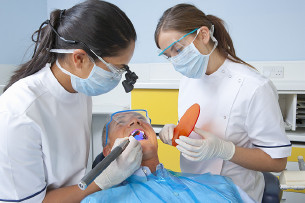

In [76]:
Image.open(metadata['full_path'][250])

In [82]:
print(metadata['full_path'][250])
print(imgName[250])
print(label[0])

/content/MAFA/images/train_00000251.jpg
['train_00000251.jpg']
[[ 68  37  62  62 115  70 124  72   2  29  56  63   1   3   2   2   5  -1
   -1  -1  -1]
 [163  37  43  43 169  57 178  50   7   9  44  43   1   3   2   1   1  -1
   -1  -1  -1]]


2.2 Save annotations of each image

In [89]:
def slice_arr(x):
  y = []
  for b in x:
    b = b[0:4]
    y.append(b)
  return y

metadata['annotations'] = label[0:1000]
metadata['annotations'] = metadata.annotations.apply(lambda x: slice_arr(x))

Have a look inside the metadata

In [90]:
print(metadata.head())

           image_name                                full_path  \
0  train_00000001.jpg  /content/MAFA/images/train_00000001.jpg   
1  train_00000002.jpg  /content/MAFA/images/train_00000002.jpg   
2  train_00000003.jpg  /content/MAFA/images/train_00000003.jpg   
3  train_00000004.jpg  /content/MAFA/images/train_00000004.jpg   
4  train_00000005.jpg  /content/MAFA/images/train_00000005.jpg   

             annotations  
0    [[95, 160, 91, 91]]  
1    [[107, 82, 66, 66]]  
2  [[56, 170, 185, 185]]  
3   [[162, 208, 71, 71]]  
4     [[86, 69, 99, 99]]  


Make sure that the example we explored before is saved correctly

In [91]:
print(metadata['full_path'][250])
print(metadata['image_name'][250])
print(metadata['annotations'][250])

/content/MAFA/images/train_00000251.jpg
train_00000251.jpg
[array([68, 37, 62, 62], dtype=int16), array([163,  37,  43,  43], dtype=int16)]


## 3. Show some bounding boxes

In [92]:
def draw_boxes_on_image(path, boxes):

    image = Image.open(path)
    draw = ImageDraw.Draw(image, 'RGBA')
    width, height = image.size

    for b in boxes:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h

        fill = (255, 255, 255, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )
    return image

train_00000001.jpg
[array([ 95, 160,  91,  91], dtype=int16)]


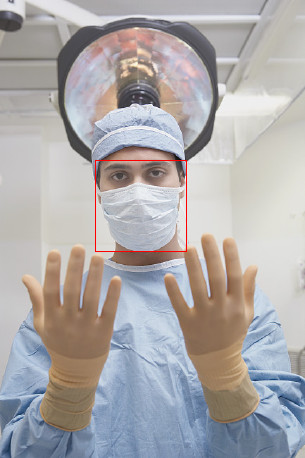

In [94]:
i = random.randint(0, len(metadata) - 1)  # choose a random image
print(metadata.image_name[i])
some_boxes = metadata.annotations[i]
print(some_boxes)
draw_boxes_on_image(metadata.full_path[i], some_boxes)

## 4. Represent Data in JSON files

Create a new folder for the new converted dataset

In [78]:
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

ann_path = os.path.join(RESULT_DIR, 'annotations')
if not os.path.exists(ann_path):
  os.mkdir(ann_path)

In [150]:
def get_annotation(name, width, height):
    annotation = {
      "filename": name,
      "size": {"depth": 3, "width": width, "height": height}
    }
    objects = []
    boxes = metadata.annotations.loc[metadata["image_name"] == name]
    boxes = boxes.values[0]
    for b in boxes:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h
        objects.append({
            "bndbox": {"ymin": int(ymin), "ymax": int(ymax), "xmax": int(xmax), "xmin": int(xmin)}, 
            "name": "face"
        })
    annotation["object"] = objects
    return annotation

In [151]:
for T in tqdm(metadata.itertuples()):
    # get width and height of an image
    image = cv2.imread(T.full_path)
    h, w, c = image.shape
    assert c == 3
    
    # name of the image
    name = T.image_name
    assert name.endswith('.jpg')
    
    # save annotation for it
    d = get_annotation(name, w, h)
    json_name = name[:-4] + '.json'
    json.dump(d, open(os.path.join(RESULT_DIR, 'annotations', json_name), 'w')) 

61it [00:00, 287.67it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  del sys.path[0]
1000it [00:03, 298.16it/s]


have a look inside the annotations folder

In [ ]:
%cd /content/result/annotations/
!ls

look inside one of the annotations JSON files

In [157]:
a_file = open("train_00000251.json", "r")
a_json = json.load(a_file)
pretty_json = json.dumps(a_json, indent=4)
a_file.close()

print(pretty_json)

{
    "filename": "train_00000251.jpg",
    "size": {
        "depth": 3,
        "width": 305,
        "height": 203
    },
    "object": [
        {
            "bndbox": {
                "ymin": 37,
                "ymax": 99,
                "xmax": 130,
                "xmin": 68
            },
            "name": "face"
        },
        {
            "bndbox": {
                "ymin": 37,
                "ymax": 80,
                "xmax": 206,
                "xmin": 163
            },
            "name": "face"
        }
    ]
}
